# Benchmarking Machine Learning Models for Predicting RT

## Load the Data 

In [4]:
from pyteomics import mgf, auxiliary
import json
import numpy as np
import pandas as pd
import mmh3
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
import matplotlib.pyplot as plt

import os
cuda_path = 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v10.0\\bin'
cudnn_path = 'D:\\Work\\software\\cuda\\bin'
os.environ["PATH"] += os.pathsep + cuda_path
os.environ["PATH"] += os.pathsep + cudnn_path
import keras
import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session

In [5]:
fp_data = pd.read_csv('data/fgmat_use.csv')

## Split the Dataset  

In [6]:
fp = fp_data.values[:,4:]
rt = fp_data['scan'].values/10

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(fp, rt, test_size=0.2, random_state=19)

In [9]:
fp_data.head(5)

,Unnamed: 0,Unnamed: 0.1,scan,pid,F1,F2,F3,F4,F5,F6,...,F1015,F1016,F1017,F1018,F1019,F1020,F1021,F1022,F1023,F1024
0,0,5139,935,5139,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3505,6878,3505,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
2,2,2159,5907,2159,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,3,1340,5836,1340,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,3344,5790,3344,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Deep Neural Network

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError

def dnn(input_dim):
    model = Sequential()
    model.add(Dense(1000, input_dim=input_dim, kernel_initializer='normal',kernel_regularizer = l2(0.0001), activation='relu'))
    model.add(Dense(500, kernel_initializer='normal',kernel_regularizer = l2(0.0001), activation='relu'))
    model.add(Dense(200, kernel_initializer='normal',kernel_regularizer = l2(0.0001), activation='relu'))
    model.add(Dense(100, kernel_initializer='normal',kernel_regularizer = l2(0.0001), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01),metrics=['mae'])
    return model

model = dnn(fp.shape[1])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              1025000   
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 1,645,901
Trainable params: 1,645,901
Non-trainable params: 0
_________________________________________________________________


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau

#rdlr = ReduceLROnPlateau(min_lr=1e-4, monitor='val_mean_squared_error', verbose=1,factor=0.8,patience=20)
save_dir = os.path.join(os.getcwd(), 'models')
model_name = 'METLIN_dnn.{epoch:03d}.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_mae',
                             verbose=1,
                             save_best_only=True)

model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test), callbacks=[checkpoint])

Epoch 1/20
1998/1999 [============================>.] - ETA: 0s - loss: 23794.2012 - mae: 94.8343
Epoch 00001: val_mae improved from inf to 78.99678, saving model to /Users/Alice/Downloads/SMRT_DNN/models/METLIN_dnn.001.h5
1999/1999 [==============================] - 63s 31ms/step - loss: 23790.5625 - mae: 94.8245 - val_loss: 12863.2344 - val_mae: 78.9968
Epoch 2/20
1998/1999 [============================>.] - ETA: 0s - loss: 11858.8311 - mae: 76.3769
Epoch 00002: val_mae improved from 78.99678 to 70.66073, saving model to /Users/Alice/Downloads/SMRT_DNN/models/METLIN_dnn.002.h5
1999/1999 [==============================] - 60s 30ms/step - loss: 11857.7617 - mae: 76.3782 - val_loss: 10967.0469 - val_mae: 70.6607
Epoch 3/20
1999/1999 [==============================] - ETA: 0s - loss: 10407.8828 - mae: 70.2490
Epoch 00003: val_mae did not improve from 70.66073
1999/1999 [==============================] - 58s 29ms/step - loss: 10407.8828 - mae: 70.2490 - val_loss: 13369.3154 - val_mae: 85.

### Loss Functions

Text(0, 0.5, 'loss')

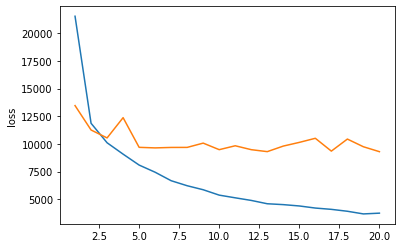

In [6]:
plt.plot(np.linspace(1,20,20),model.history.history['loss'])
plt.plot(np.linspace(1,20,20),model.history.history['val_loss'])
plt.ylabel('loss')

Text(0, 0.5, 'mae')

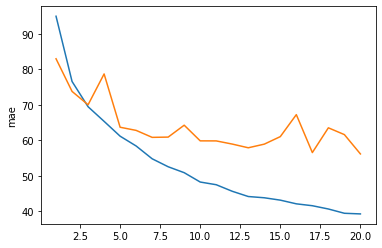

In [7]:
plt.plot(np.linspace(1,20,20),model.history.history['mae'])
plt.plot(np.linspace(1,20,20),model.history.history['val_mae'])
plt.ylabel('mae')

In [11]:
rt_pred = model.predict(x_test)

### Visualize Prediction Rate 

Text(0, 0.5, 'experimental rt')

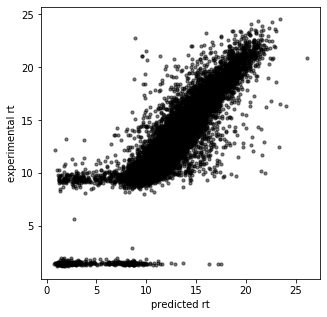

In [12]:
plt.figure(figsize=(5,5))
plt.scatter(rt_pred/60,y_test/60,s=10,c='k',alpha=0.5)
plt.xlabel('predicted rt')
plt.ylabel('experimental rt')

### Print Accuracy Metrics 

In [15]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_test/60, rt_pred/60))
print(mean_absolute_error(y_test/60, rt_pred/60))

2.94431372258915
1.1112944325116947


## Gradient Boosted Tree

In [7]:
# Gradient boosting tree
import xgboost

# Figure out parameters
xgb = xgboost.XGBRegressor(n_jobs=6) # inc the number of workers to speed up process (can use -1)
xgb.fit(x_train,y_train)
y_pred_xgb = xgb.predict(x_test)


### Print out Accuracy Metrics

In [11]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Print accuracy measures
print(mean_squared_error(y_test/60, y_pred_xgb/60))
print(mean_absolute_error(y_test/60, y_pred_xgb/60))

4.702494280313585
1.5552753093209695
[787.4 832.8 121.5 ... 998.3 983.8 886.5]


### Visualize the Prediction Rate

Text(0, 0.5, 'experimental rt')

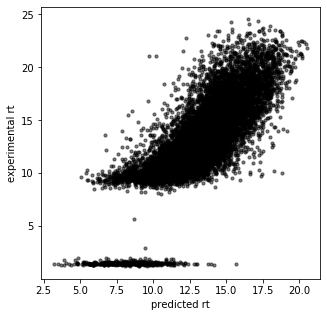

In [12]:
plt.figure(figsize=(5,5))
plt.scatter(y_pred_xgb/60,y_test/60,s=10,c='k',alpha=0.5)
plt.xlabel('predicted rt')
plt.ylabel('experimental rt')

# Visualize the Dataset Using tSNE

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
from MulticoreTSNE import MulticoreTSNE as TSNE

# Use MulticoreTSNE rather than sklearn to speed up process
tsne = TSNE(n_jobs=6, metric='jaccard')

In [13]:
tsne_obj = tsne.fit_transform(fp)
tsne_df = pd.DataFrame()
tsne_df['x'] = tsne_obj[:, 0]
tsne_df['y'] = tsne_obj[:, 1]

In [15]:
# Save the results 
tsne_df.to_pickle("jaccardTsneResults.pkl")

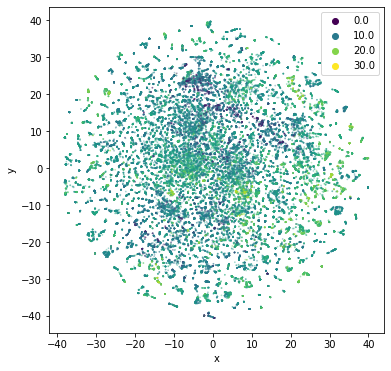

In [25]:
a4_dims = (6, 6) # Make the figure a square
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(x="x", y="y", hue=rt/60, ax=ax,
                     data=tsne_df, s=3, alpha=.4, palette="viridis",
                     linewidth=0) #inc res, square shape (inc height)